#### Required Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import recall_score , classification_report , confusion_matrix  ,roc_curve , roc_auc_score , accuracy_score
from sklearn.metrics import precision_recall_curve , auc ,f1_score , precision_score , recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s4e1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
df_sample = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")
df_train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [3]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df_train.shape

(165034, 14)

In [5]:
df_test.shape

(110023, 13)

In [6]:
df_train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

It is an imbalanced classification problem. 

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [8]:
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
df_train.duplicated().sum()

0

In [11]:
df_train.drop(columns=['id','CustomerId','Surname'], inplace=True)

There is not any duplicate and null values in the dataset.

#### Filtering Numerical and Categorical Columns

In [12]:
# extracted categorical columns having non-unique value less than 10
categ_columns = []
for col in df_train.columns:
    if df_train[col].nunique()<=10:
        if col!='Exited':
            categ_columns.append(col) 
print('categorical numericals columns are {}'.format(categ_columns))

categorical numericals columns are ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [13]:
# extracted numerical columns
Num_cols = [col for col in df_train.columns if col not in categ_columns]
Num_cols.remove('Exited')
print('numericals columns are {}'.format(Num_cols)) 

numericals columns are ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


In [14]:
df_numeric = df_train[Num_cols].copy()
df_categ = df_train[categ_columns].copy()

In [15]:
df_numeric.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,668,33.0,3,0.00,181449.97
1,627,33.0,1,0.00,49503.50
2,678,40.0,10,0.00,184866.69
3,581,34.0,2,148882.54,84560.88
4,716,33.0,5,0.00,15068.83


In [16]:
df_categ.head()

,Geography,Gender,NumOfProducts,HasCrCard,IsActiveMember
0,France,Male,2,1.0,0.0
1,France,Male,2,1.0,1.0
2,France,Male,2,1.0,0.0
3,France,Male,1,1.0,1.0
4,Spain,Male,2,1.0,1.0


#### EDA

In [17]:
# create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'red','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

In [18]:
#create counts of df_train for plotting categorical variable- Exited; 0-No, 1-Yes
loan = np.unique(df_train['Exited'], return_counts=True)
print('loan = {}\n'.format(loan))

loan = (array([0, 1]), array([130113,  34921]))



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


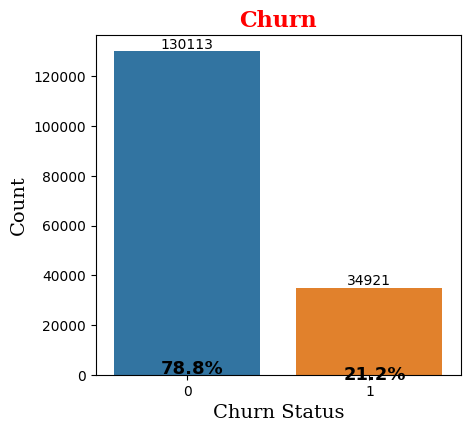

In [19]:
# Display a frequency distribution for Churn. 
fig = plt.figure(figsize=[16,15]);
ax1 = fig.add_subplot(3, 3, 2);
sns.barplot(x=list(loan[0]), y=list(loan[1]), ax=ax1 );
#below two lines of codes of codes are for showing percentage values in bargraph
ax1.text(0.2, 2500, '{}%' .format(str(round(loan[1][0]/sum(loan[1])*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
ax1.text(1.2, 200, '{}%' .format(str(round(loan[1][1]/sum(loan[1])*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
ax1.set_title('Churn', fontdict=axtitle_dict);
ax1.set_xlabel('Churn Status', fontdict=axlab_dict);
ax1.set_ylabel('Count', fontdict=axlab_dict);
ax1.bar_label(ax1.containers[0])
plt.show()

#### Correlation Matric Between Numerical Variables

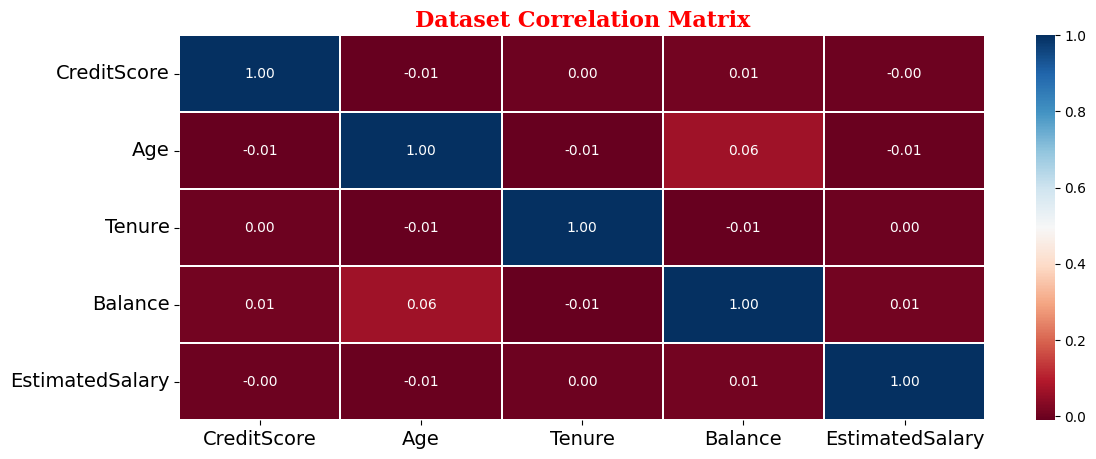

In [20]:
# plot correlation matrix heatmap
fig, ax = plt.subplots(figsize=[13,5])
sns.heatmap(df_numeric.corr(), ax=ax,  annot=True, linewidths=0.05, fmt= '.2f',cmap='RdBu')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Dataset Correlation Matrix', fontdict=axtitle_dict)
fig.show()

There is no correlation between numerical variables.

In [21]:
df_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### Bar Plots for categorical variables- Univariate Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/si

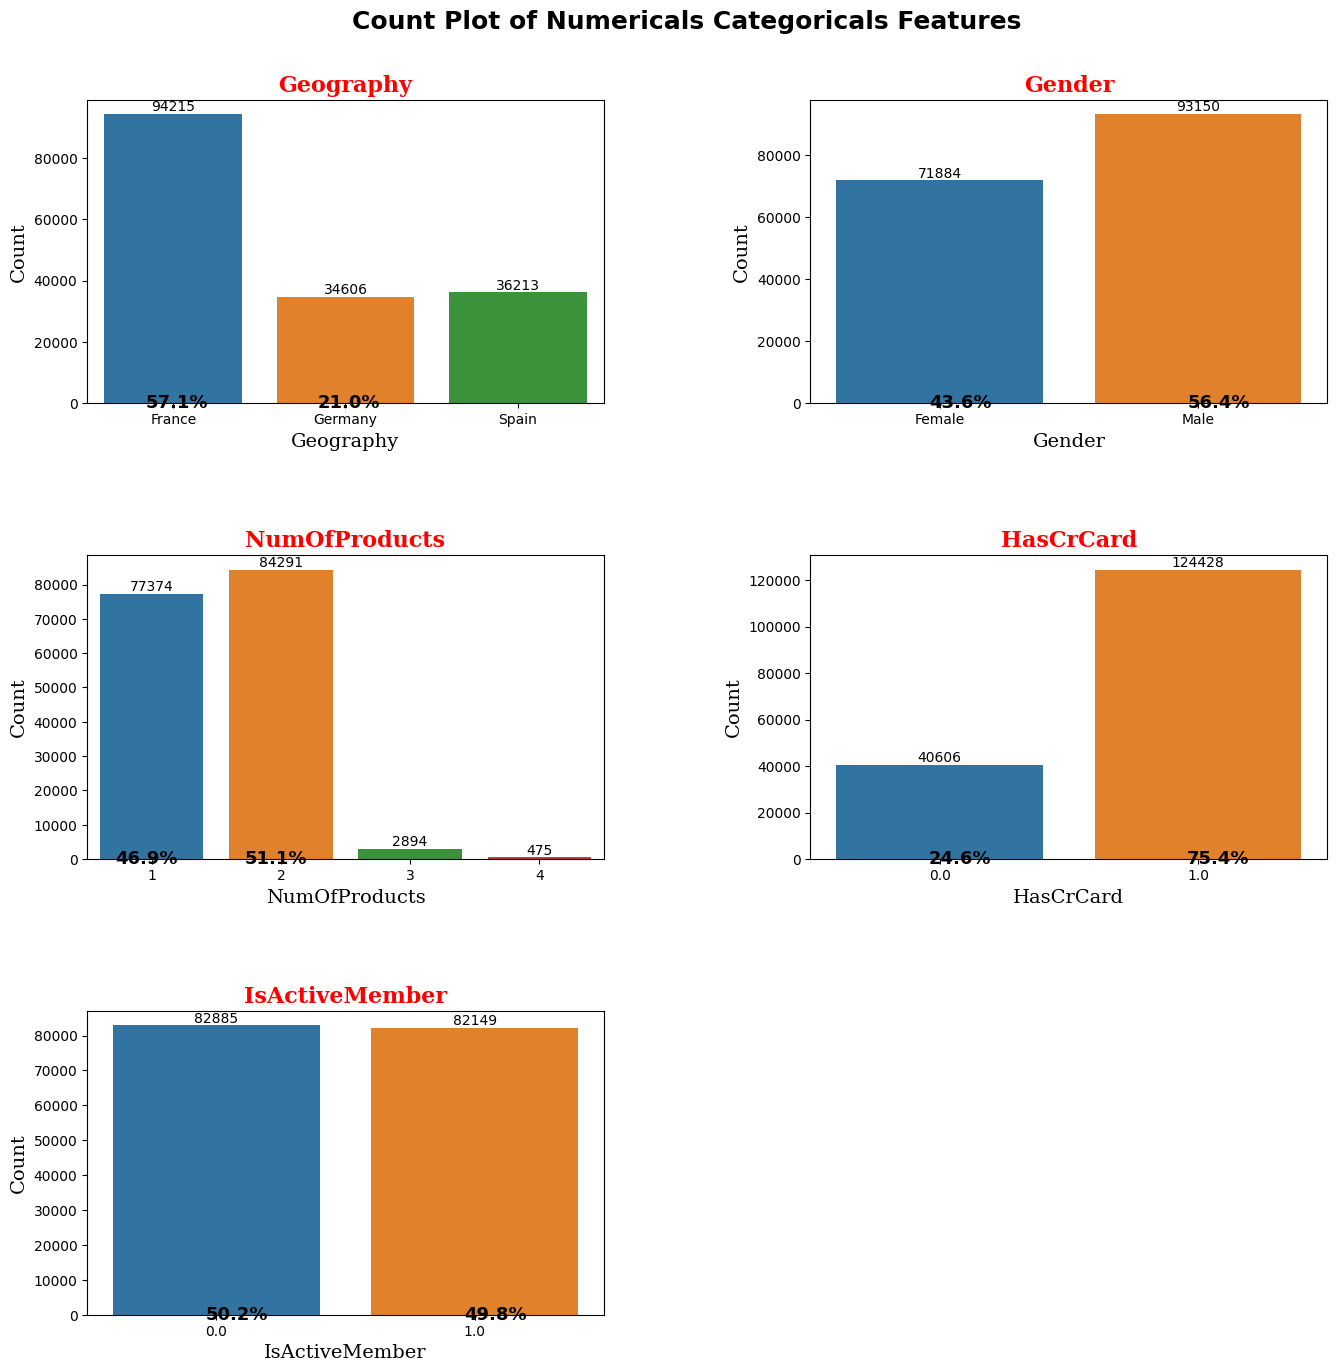

In [22]:
fig = plt.figure(figsize=[16,15])
fig.suptitle('Count Plot of Numericals Categoricals Features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i , columns in enumerate(categ_columns):
    input = np.unique(df_train[columns] , return_counts = True)
    col= 'input'
    ax1 = fig.add_subplot(3, 2, i+1);
    ax1 = sns.barplot(x=list(eval(f'{col}[0]')), y=list(eval(f'{col}[1]')))
    #The below two lines of codes are used for percentage values.
    ax1.text(0.2, 120, '{}%' .format(str(round(eval(f'{col}[1][0]')/sum(eval(f'{col}[1]'))*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
    ax1.text(1.2, 120, '{}%' .format(str(round(eval(f'{col}[1][1]')/sum(eval(f'{col}[1]'))*100,1))), ha='right', va='center', size=13, fontdict={'weight': 'bold'})
    ax1.set_title(f'{columns}', fontdict=axtitle_dict)
    ax1.set_xlabel(f'{columns}', fontdict=axlab_dict)
    ax1.set_ylabel('Count', fontdict=axlab_dict)
    ax1.bar_label(ax1.containers[0])

##### Insights
- More customers are from France.
- Number of males customers are more than female.
- There are very few customers who has taken 3-4 products.
- More than 75% customers has credit card.
- Ratio of active and non-active members are aprrox. 1.

#### Distribution Curve for Numerical Variables - Univariate Analysis

/tmp/ipykernel_27/3595898900.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_train[col],  color='dodgerblue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_27/3595898900.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function 

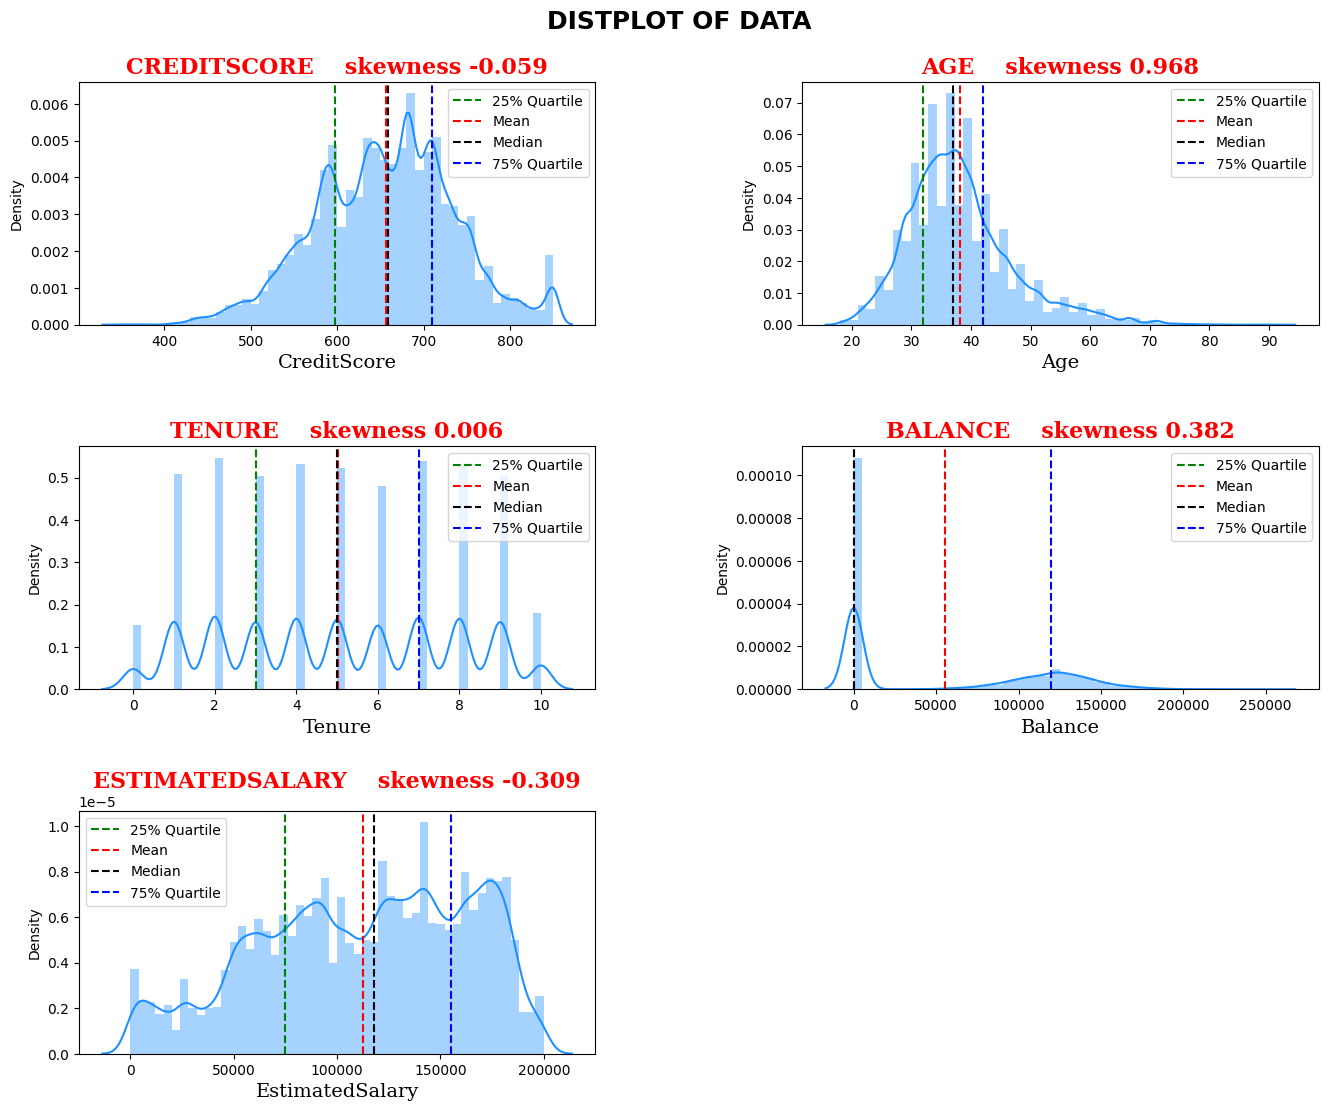

In [23]:
#create figure with 3 x 2 grid of subplots
fig = plt.figure(figsize=[16,12])
fig.suptitle('DISTPLOT OF DATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(Num_cols):
    ax = fig.add_subplot(3, 2, i+1)
    ax = sns.distplot(df_train[col],  color='dodgerblue')
    ax.axvline(df_train[col].quantile(q=0.25),color='green',linestyle='--',label='25% Quartile')
    ax.axvline(df_train[col].mean(),color='red',linestyle='--',label='Mean')
    ax.axvline(df_train[col].median(),color='black',linestyle='--',label='Median')
    ax.axvline(df_train[col].quantile(q=0.75),color='blue',linestyle='--',label='75% Quartile')
    # ax.text('skewness: {}' .format(str(round(df[col].skew(),3))), ha='right', va='center', size=11)
    ax.set_xlabel(f'{col}', fontdict=axlab_dict)
    ax.set_title(f'{col.upper()}    skewness {round(df_train[col].skew(),3)}', fontdict=axtitle_dict)
    ax.legend(fontsize=10) 

##### Insights
- Credit score of cutomers are negatively skewed.
- Age is postively skewed.
- Tenure, Balance and Estimated Salary data are showing non-normal distribution curve.

#### Outliers Detection

In [24]:
colours = ['forestgreen','dodgerblue','goldenrod', 'coral' , 'silver' , 'gold' , 'dodgerblue'];

#### Box Plots

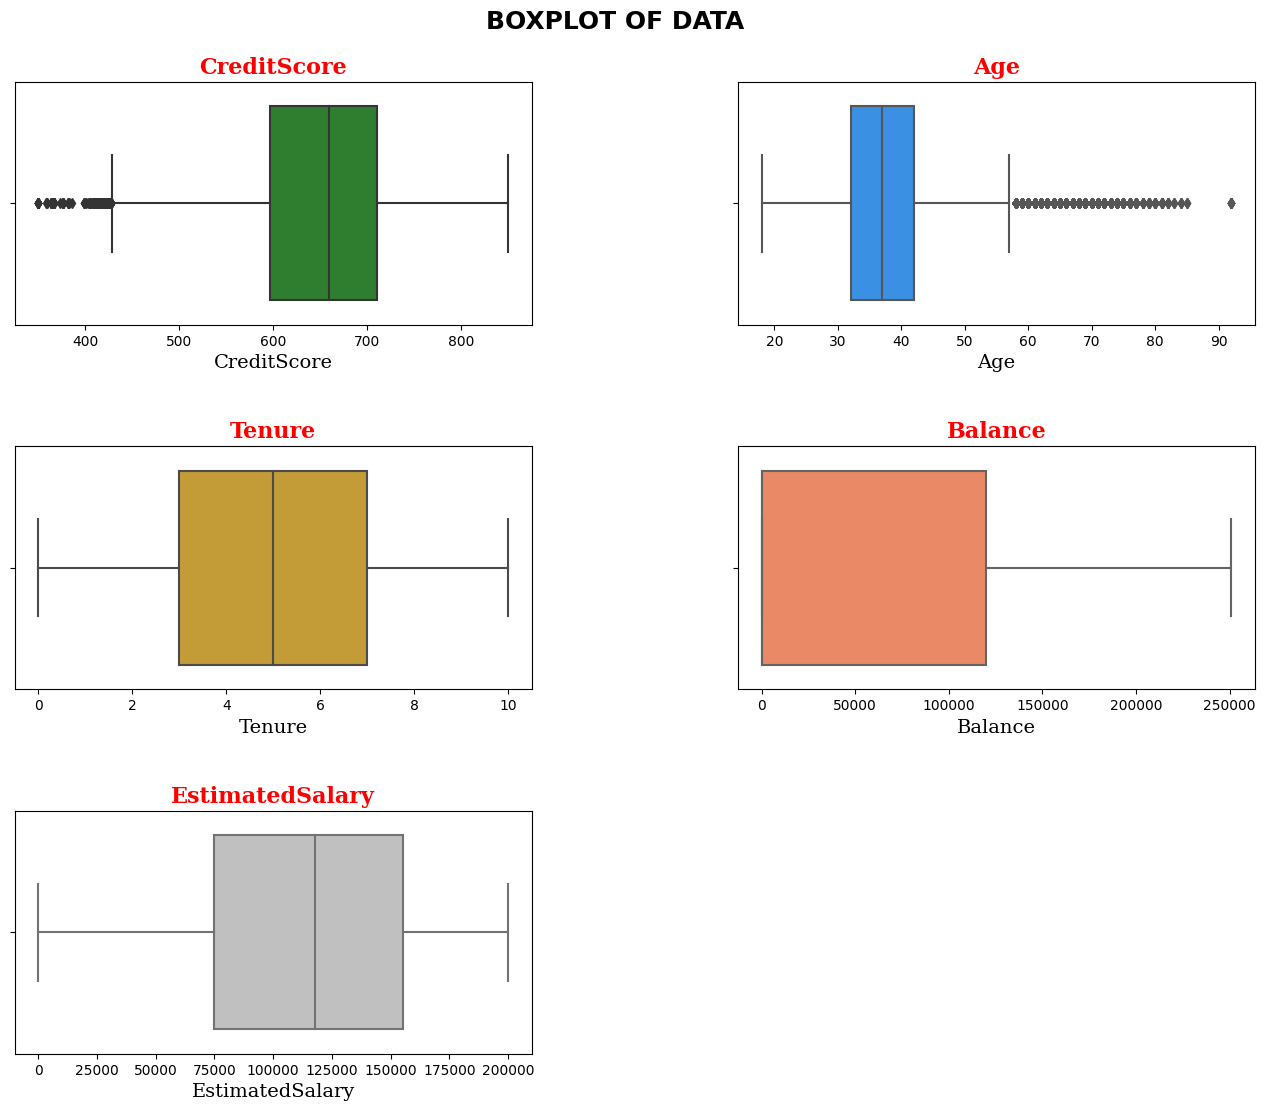

In [25]:
#create figure with 3 x 2 grid of subplots
fig = plt.figure(figsize=[16,12])
fig.suptitle('BOXPLOT OF DATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(Num_cols):  
    ax1 = fig.add_subplot(3, 2, i+1);
    ax1 = sns.boxplot(data = df_train, x=col ,  color= colours[i]);
 
    ax1.set_title(f'{col}', fontdict=axtitle_dict) 
    ax1.set_xlabel(f'{col}', fontdict=axlab_dict)

In [26]:
df_num = df_train[Num_cols]
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

CreditScore         True
Age                 True
Tenure             False
Balance            False
EstimatedSalary    False
dtype: bool

We are not removing outliers. Since it is not much values.

#### Bivariate Analysis - Categorical Variables

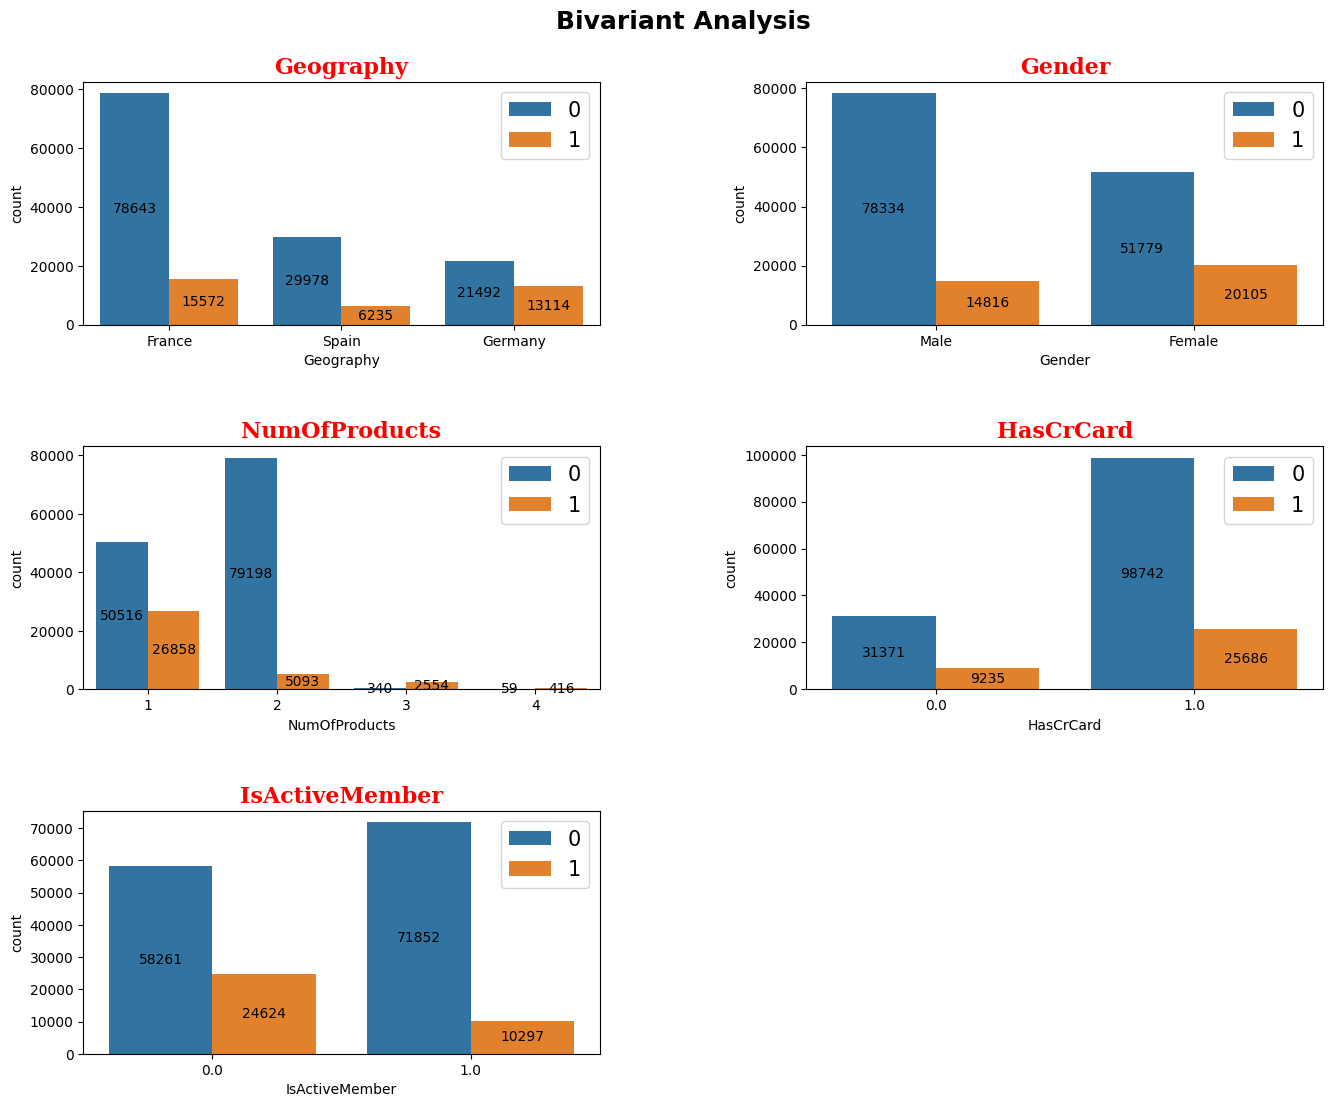

In [27]:
#create figure with 3 x 3 grid of subplots
fig = plt.figure(figsize=[16,12])
fig.suptitle('Bivariant Analysis', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(categ_columns):
    a = fig.add_subplot(3, 2, i+1)
    a=sns.countplot(x = df_train[col] , ax=a , hue = df_train['Exited'] )
    a.set_title(col , fontdict=axtitle_dict)
    a.bar_label(a.containers[0] , label_type='center') 
    a.bar_label(a.containers[1] , label_type='center')
    a.legend(fontsize=15)

#### Bivariate Analysis - Numerical Variables

/tmp/ipykernel_27/1245067605.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x =df_train[df_train['Exited']==0][col],  color='dodgerblue' , ax=a ,  hist =False)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_27/1245067605.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar

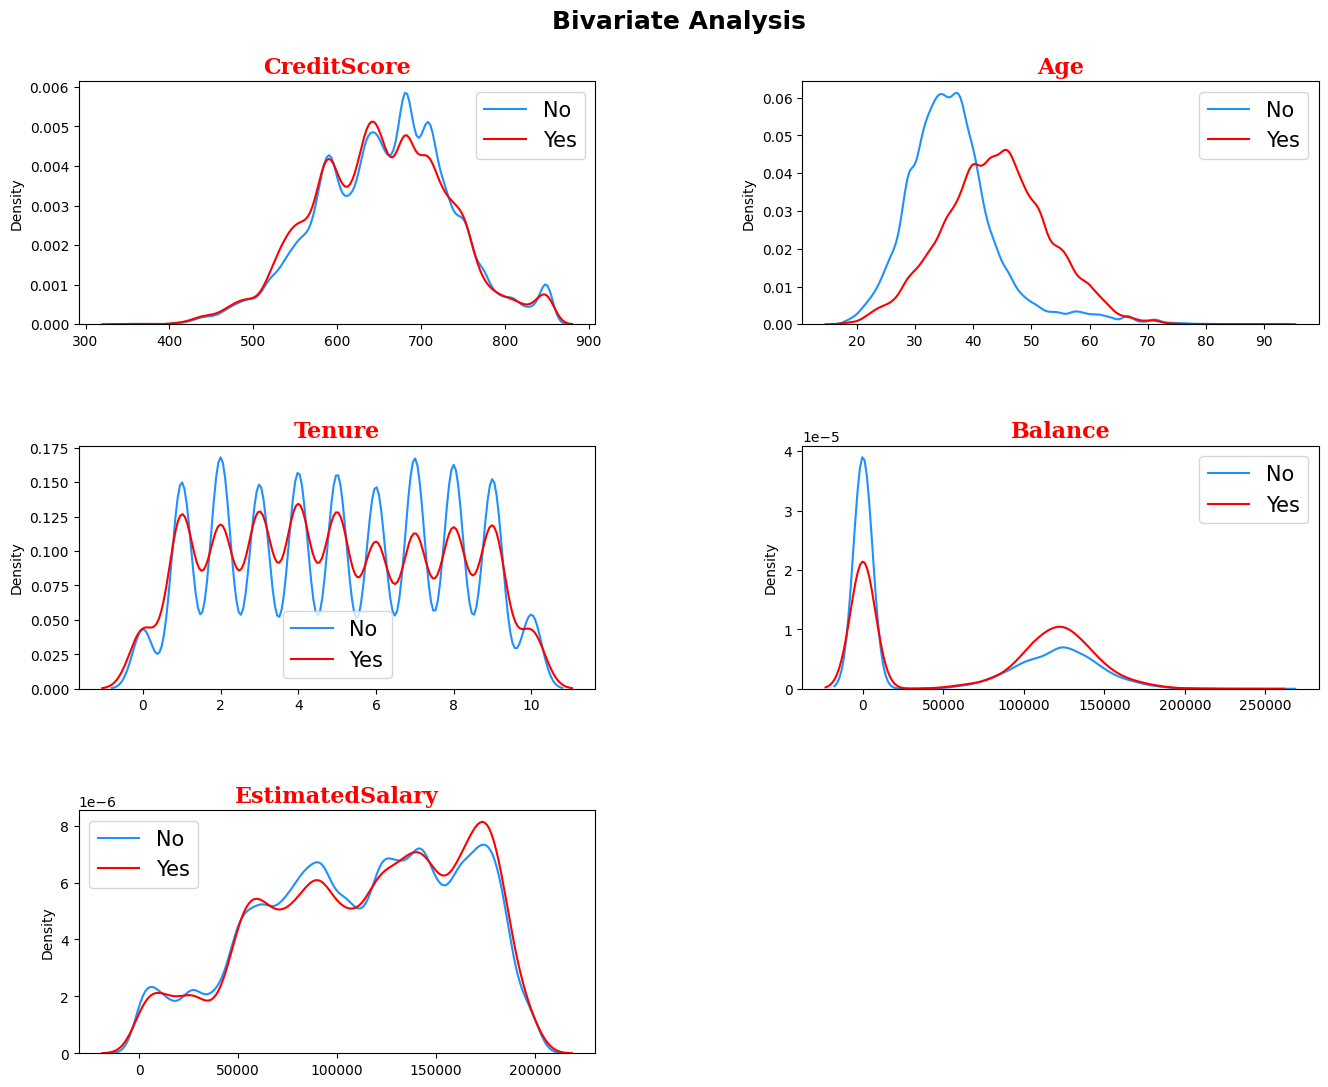

In [28]:
fig = plt.figure(figsize=[16,12])
fig.suptitle('Bivariate Analysis', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(Num_cols):
    a = fig.add_subplot(3, 2, i+1)
    sns.distplot(x =df_train[df_train['Exited']==0][col],  color='dodgerblue' , ax=a ,  hist =False)
    sns.distplot(x =df_train[df_train['Exited']==1][col],  color='red' , ax=a , hist =False) 
    a.set_title(col , fontdict=axtitle_dict)    
    labels = ['No' , 'Yes']
    a.legend( labels  , fontsize = 15)

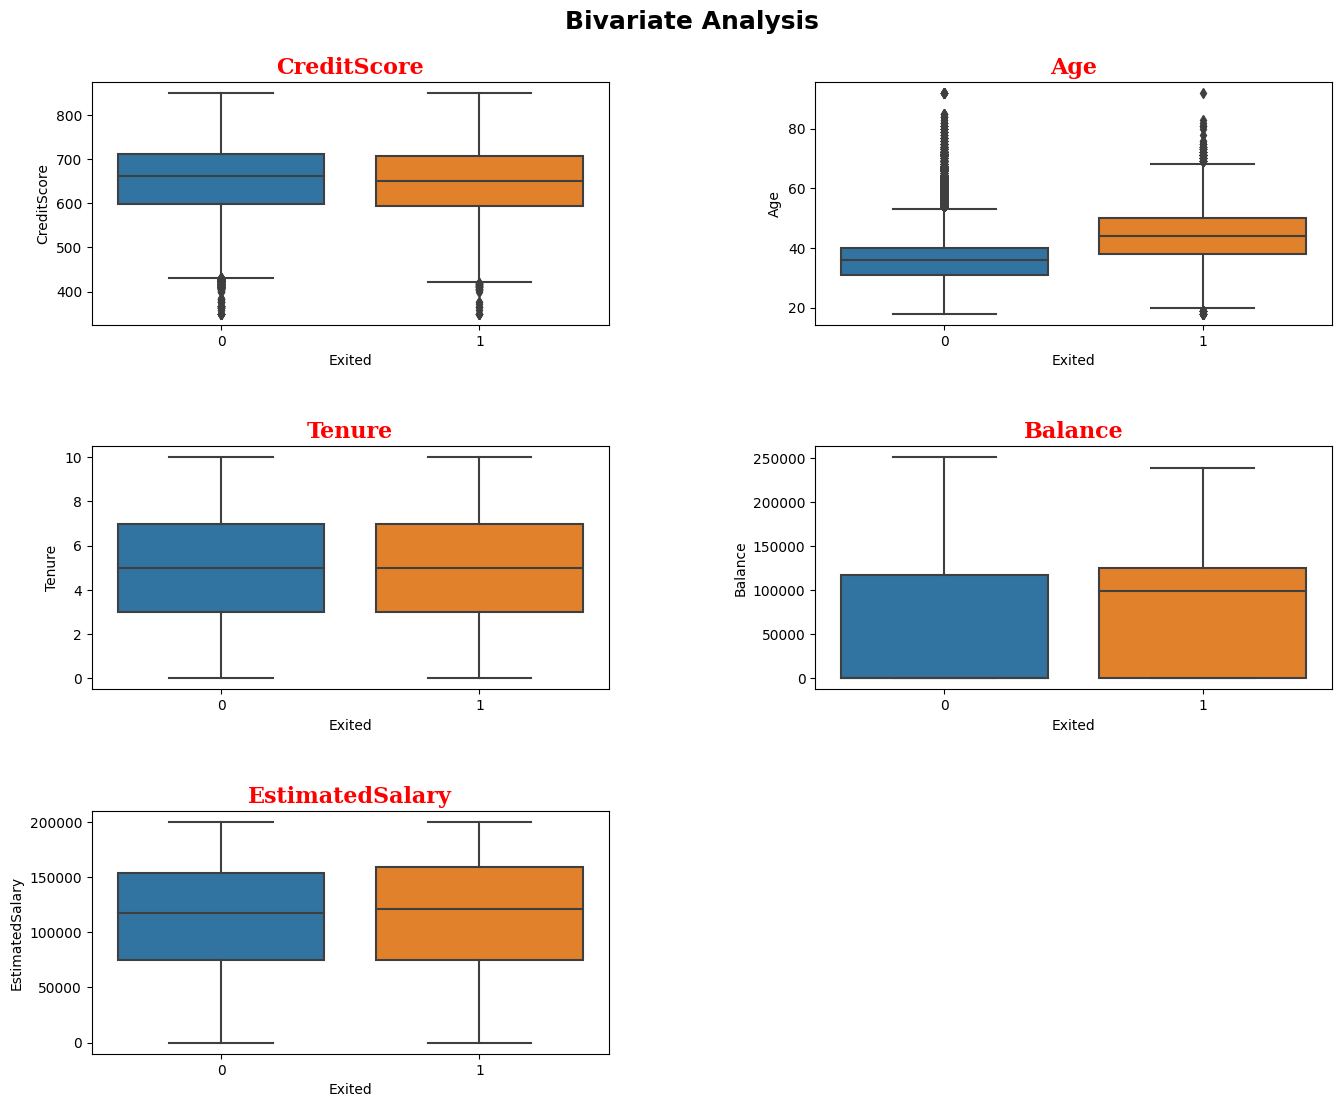

In [29]:
#create figure with 3 x 2 grid of subplots
fig = plt.figure(figsize=[16,12])
fig.suptitle('Bivariate Analysis', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(Num_cols):
    a = fig.add_subplot(3, 2, i+1)
    a=sns.boxplot(x = 'Exited' , y =col , ax=a  , data = df_train)
    a.set_title(col , fontdict=axtitle_dict)

#### Encoding

In [30]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.9+ MB


In [32]:
enc = LabelEncoder()

categorical_text_features = ["Geography", "Gender"]

for cat_feat in categorical_text_features:
    df_train[cat_feat] = enc.fit_transform(df_train[cat_feat])

In [33]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


#### Addition of More Features

In [34]:
def add_new_features(df):
    df['Geo_Gender'] = df['Geography'] + df['Gender'] + 10
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    return df

In [35]:
df_train = add_new_features(df_train)

In [36]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_Gender,Balance_to_Salary_Ratio,IsActive_by_CreditCard,Products_Per_Tenure
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,11,0.000000,0.0,1.5
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,11,0.000000,1.0,0.5
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,11,0.000000,0.0,5.0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,11,1.760655,1.0,2.0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,13,0.000000,1.0,2.5


#### Train_Test Split and Balancing of Data- Oversampling

In [37]:
df_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geo_Gender', 'Balance_to_Salary_Ratio',
       'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')

In [38]:
X = df_train.drop("Exited",axis=1)
y = df_train['Exited']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X_train , X_test , y_train , y_test = train_test_split(X , y  ,test_size = 0.3 , random_state = 42, stratify=y)
# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='all',random_state=42)
X_train = scaler.fit_transform(X_train)
# Fit and apply the resampling on the training data only
X_train_1, y_train_1 = oversampler.fit_resample(X_train, y_train)
X_test = scaler.fit_transform(X_test)

#### Modelling

In [39]:
# Create a logistic regression model
model_lr = LogisticRegression(random_state=0)
# Fit the model on the training data
model_lr.fit(X_train_1, y_train_1)
# Use cross-validation to assess the model's performance
cv_scores = cross_val_score(model_lr, X_train_1, y_train_1, scoring='accuracy')
# Calculate the mean accuracy score from cross-validation
mean_accuracy = cv_scores.mean()
print("Cross-Validation Mean Accuracy:", mean_accuracy)
# Predict on the test data
y_pred = model_lr.predict(X_test)
# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Cross-Validation Mean Accuracy: 0.7449054622386907
Test Accuracy: 0.7451677405021107


In [40]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.75
Confusion Matrix:
[[29100  9935]
 [ 2682  7794]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.82     39035
           1       0.44      0.74      0.55     10476

    accuracy                           0.75     49511
   macro avg       0.68      0.74      0.69     49511
weighted avg       0.81      0.75      0.76     49511



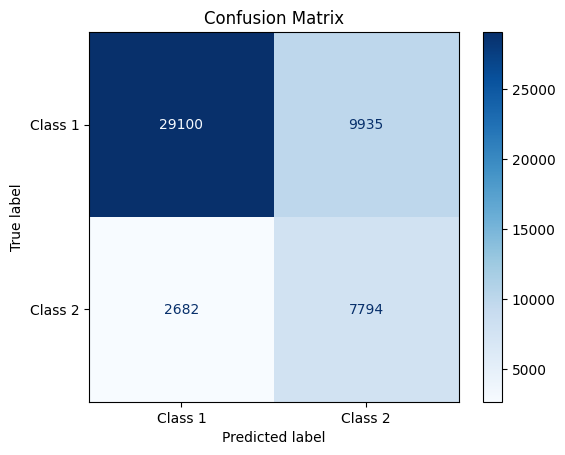

In [41]:
class_labels = ['Class 1', 'Class 2']
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix')
plt.show()

##### XGBosst

In [42]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            # missing=None,
                            seed=42)
model_xgb.fit(X_train_1,
            y_train_1,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])# Import necessary libraries


# Use cross-validation to assess the model's performance
cv_scores_xgb = cross_val_score(model_xgb, X_train_1, y_train_1, scoring='accuracy')

# Calculate the mean accuracy score from cross-validation
mean_accuracy_xgb = cv_scores_xgb.mean()
print("Cross-Validation Mean Accuracy (XGBoost):", mean_accuracy_xgb)

# Predict on the test data
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model on the test data
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Test Accuracy (XGBoost):", test_accuracy_xgb)


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.87411
[1]	validation_0-auc:0.87733
[2]	validation_0-auc:0.88141
[3]	validation_0-auc:0.88294
[4]	validation_0-auc:0.88341
[5]	validation_0-auc:0.88372
[6]	validation_0-auc:0.88467
[7]	validation_0-auc:0.88515
[8]	validation_0-auc:0.88547
[9]	validation_0-auc:0.88572
[10]	validation_0-auc:0.88582
[11]	validation_0-auc:0.88595
[12]	validation_0-auc:0.88627
[13]	validation_0-auc:0.88637
[14]	validation_0-auc:0.88644
[15]	validation_0-auc:0.88651
[16]	validation_0-auc:0.88657
[17]	validation_0-auc:0.88647
[18]	validation_0-auc:0.88638
[19]	validation_0-auc:0.88628
[20]	validation_0-auc:0.88630
[21]	validation_0-auc:0.88618
[22]	validation_0-auc:0.88601
[23]	validation_0-auc:0.88590
[24]	validation_0-auc:0.88583
[25]	validation_0-auc:0.88586
Cross-Validation Mean Accuracy (XGBoost): 0.8316058839767446
Test Accuracy (XGBoost): 0.8118397931772737


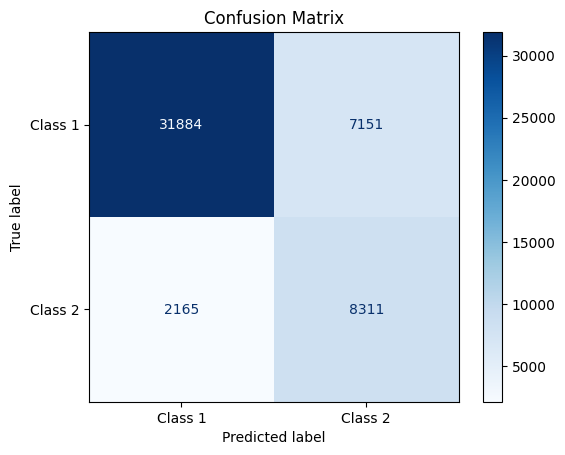

In [43]:
class_labels = ['Class 1', 'Class 2']
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
# Plot the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix')
plt.show()